In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cmap = plt.cm.tab10

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE 

In [199]:
data = pd.read_csv("../dataset/german_credit_data_withrisk.csv", index_col=0)

In [200]:
num_impute = "mean" # One of ["mean", "zero", "infinity"]
cat_impute = "mode" # One of ["mode", "none"]
random_state = 42

In [201]:
job_index2word = {
    0: "unskilled and non-resident", 
    1: "unskilled and resident", 
    2: "skilled", 
    3: "highly skilled"
}
def assign_job_type(col):
    return job_index2word[col]

In [202]:
data.Job = data.Job.apply(assign_job_type)

In [203]:
cat_cols = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
num_cols = ['Age', 'Credit amount', 'Duration']

In [204]:
def impute_with_mean(df):
    out = pd.DataFrame(df)
    for col in df.columns:
        if col in num_cols:
            out.loc[out[col].isna(), col] = df[col].mean()
    return out
def impute_with_zero(df):
    out = pd.DataFrame(df)
    for col in df.columns:
        if col in num_cols:
            out.loc[out[col].isna(), col] = 0.0
    return out


def impute_with_infinity(df):
    out = pd.DataFrame(df)
    for col in df.columns:
        if col in num_cols:
            out.loc[out[col].isna(), col] = float("inf")
    return out
def impute_with_mode(df):
    out = pd.DataFrame(df)
    for col in df.columns:
        if col in cat_cols:
            out.loc[out[col].isna(), col] = df[col].mode().iat[0]
    return out
def impute_with_none(df):
    out = pd.DataFrame(df)
    for col in df.columns:
        if col in cat_cols:
            out.loc[out[col].isna(), col] = "None"
    return out

In [205]:
def get_impute_function(name):
    assert name in ["mean", "zero", "infinity", "mode", "none"]
    if name == "mean":
        return impute_with_mean
    elif name == "zero":
        return impute_with_zero
    elif name == "infinity":
        return impute_with_infinity
    elif name == "mode":
        return impute_with_mode
    else:
        return impute_with_none

In [206]:
def impute_missing_values(df, num_impute, cat_impute):
    num_impute_function = get_impute_function(num_impute)
    cat_impute_function = get_impute_function(cat_impute)
    new_df = num_impute_function(df)
    new_df = cat_impute_function(df)
    return new_df

In [207]:
data.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [208]:
data = impute_missing_values(data, num_impute, cat_impute)

In [209]:
data.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [210]:
(data.Risk == "good").sum()

700

In [211]:
(data.Risk == "bad").sum()

300

In [212]:
def cat2onehot(df):
    output = df.copy()
    for col in cat_cols:
        dummies = pd.get_dummies(df[col], drop_first=True)
        output = pd.concat([dummies, output], axis=1)
        output.drop(col, axis=1, inplace=True)
    return output

In [213]:
data = cat2onehot(data)

In [214]:
data.columns

Index(['car', 'domestic appliances', 'education', 'furniture/equipment',
       'radio/TV', 'repairs', 'vacation/others', 'moderate', 'rich',
       'moderate', 'quite rich', 'rich', 'own', 'rent', 'skilled',
       'unskilled and non-resident', 'unskilled and resident', 'male', 'Age',
       'Credit amount', 'Duration', 'Risk'],
      dtype='object')

In [215]:
sm = SMOTE(random_state=42)


In [216]:
def normalize_numeric(df, num_cols):
    scalers = {}
    for col in num_cols:
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))
        scalers[col] = scaler
    return df, scalers

In [217]:
data, scalers = normalize_numeric(data, num_cols)

In [218]:
data["Age"].mean()

5.329070518200751e-17

In [219]:
data["Age"].std()

1.0005003753127737

In [220]:
X = data[data.columns[:-1]].values
y = data[data.columns[-1]].values

In [221]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = random_state)

In [222]:
train_x, train_y = sm.fit_resample(train_x, train_y)

In [223]:
def evaluate(model, X, y):
    y_pred = model.predict(X)
    correct = (y == y_pred).astype(np.float32)
    return correct.mean()

In [224]:
names = [
#         "Nearest Neighbors", 
#          "RBF SVM",
#          "Gaussian Process",
         "Decision Tree", 
         "Random Forest", 
         "Neural Net", 
         "AdaBoost",
#          "Naive Bayes", 
#          "QDA", 
         "Logistic Regression",
         "Gradient Boosting",
         "Extra Trees"
        ]

classifiers = [
#     KNeighborsClassifier(3),
#     SVC(gamma=2, C=0.25, probability=True),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    GradientBoostingClassifier(),
    ExtraTreesClassifier()

]

In [225]:
data.head()

,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others,moderate,rich,moderate,...,own,rent,skilled,unskilled and non-resident,unskilled and resident,male,Age,Credit amount,Duration,Risk
0,0,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,1,2.766456,-0.745131,-1.236478,good
1,0,0,0,0,1,0,0,1,0,0,...,1,0,1,0,0,0,-1.191404,0.949817,2.248194,bad
2,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,1,1.183312,-0.416562,-0.738668,good
3,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0.831502,1.634247,1.750384,good
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1.535122,0.566664,0.256953,bad


In [226]:
classifiers = {names[i]:classifiers[i] for i in range(len(names))}
for classifier_name in classifiers:
    classifier = classifiers[classifier_name]
    classifier.fit(train_x, train_y)
    train_acc = evaluate(classifier, train_x, train_y)
    test_acc = evaluate(classifier, test_x, test_y)
    print("{} accuracy\n\t\t- train:\t {:.2f}% \n\t\t- test:  \t {:.2f}%".format(classifier_name, train_acc * 100, test_acc * 100))

Decision Tree accuracy
		- train:	 73.48% 
		- test:  	 64.50%
Random Forest accuracy
		- train:	 71.61% 
		- test:  	 63.50%
Neural Net accuracy
		- train:	 77.95% 
		- test:  	 65.00%
AdaBoost accuracy
		- train:	 74.73% 
		- test:  	 64.50%
Logistic Regression accuracy
		- train:	 67.05% 
		- test:  	 65.00%
Gradient Boosting accuracy
		- train:	 86.70% 
		- test:  	 68.50%
Extra Trees accuracy
		- train:	 100.00% 
		- test:  	 69.00%


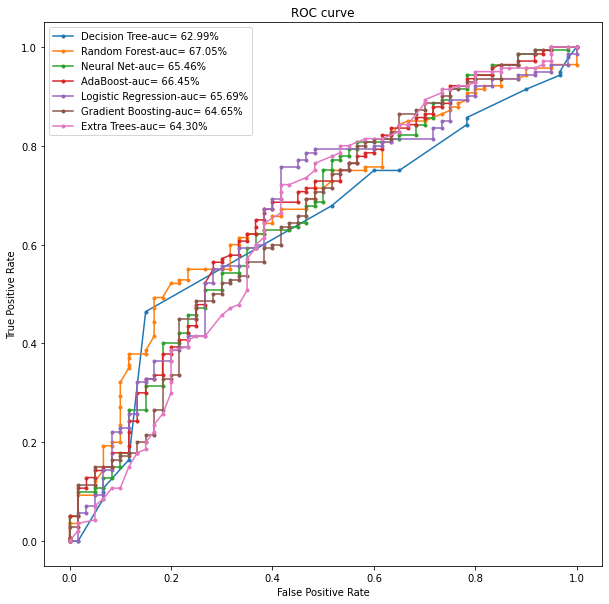

In [227]:
plt.figure(figsize=(10, 10))
plt.title("ROC curve".format(classifier_name))
for classifier_name in classifiers:
  
    classifier = classifiers[classifier_name]
    
    lr_probs = classifier.predict_proba(test_x)
    lr_probs = lr_probs[:, 1]
    lr_fpr, lr_tpr, _ = roc_curve(test_y=="good", lr_probs)
    a = auc(lr_fpr, lr_tpr)
    plt.plot(lr_fpr, lr_tpr, marker='.', label=classifier_name+"-auc= {:.2f}%".format(a * 100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
   

In [228]:
train_preds = dict()

for classfier_name in classifiers:
    train_preds[classfier_name] = classifiers[classfier_name].predict(train_x)


In [229]:
train_preds_df = pd.DataFrame(train_preds)
train_preds_df.head()

,Decision Tree,Random Forest,Neural Net,AdaBoost,Logistic Regression,Gradient Boosting,Extra Trees
0,good,bad,good,good,bad,good,good
1,bad,good,good,good,bad,good,good
2,bad,bad,good,bad,bad,bad,good
3,bad,bad,bad,bad,bad,good,good
4,good,bad,good,good,good,good,good


In [230]:
val_preds = dict()

for classfier_name in classifiers:
    val_preds[classfier_name] = classifiers[classfier_name].predict(test_x)


In [231]:
val_preds_df = pd.DataFrame(val_preds)
val_preds_df.head()

,Decision Tree,Random Forest,Neural Net,AdaBoost,Logistic Regression,Gradient Boosting,Extra Trees
0,bad,bad,good,bad,bad,good,good
1,bad,bad,bad,bad,bad,bad,bad
2,good,bad,bad,bad,bad,bad,bad
3,good,good,good,good,good,good,good
4,bad,bad,bad,bad,bad,bad,good


In [232]:
new_train_x = (train_preds_df.values == "good").astype(float)
new_test_x = (val_preds_df.values == "good").astype(float)

In [233]:
train_y  = (train_y=="good").astype(float)
test_y  = (test_y=="good").astype(float)

In [234]:
import tensorflow as tf

In [235]:
layers = tf.keras.layers

In [249]:
model = tf.keras.Sequential(
[
    layers.Dropout(0.5),
    layers.Dense(32, activation=tf.keras.activations.elu, kernel_regularizer="l2"),
#     layers.BatchNormalization(),
#     layers.Dense(64, activation=tf.keras.activations.elu, kernel_regularizer="l1"),
    layers.Dense(1, activation="sigmoid", kernel_regularizer="l1")
]
)

In [250]:
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=1e-4), metrics=["accuracy"])

In [251]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('best-model.h5', save_weights_only=True, save_best_only=True, monitor='val_accuracy', mode="auto")


In [252]:
model.fit(new_train_x, train_y,  validation_data=(new_test_x, test_y), epochs=20 , callbacks=[mcp_save])

Epoch 1/20
35/35 [==============================] - 1s 22ms/step - loss: 0.9224 - accuracy: 0.4045 - val_loss: 0.9048 - val_accuracy: 0.3550
Epoch 2/20
35/35 [==============================] - 0s 6ms/step - loss: 0.8955 - accuracy: 0.3562 - val_loss: 0.8746 - val_accuracy: 0.3600
Epoch 3/20
35/35 [==============================] - 0s 6ms/step - loss: 0.8680 - accuracy: 0.6232 - val_loss: 0.8504 - val_accuracy: 0.6100
Epoch 4/20
35/35 [==============================] - 0s 5ms/step - loss: 0.8498 - accuracy: 0.6777 - val_loss: 0.8305 - val_accuracy: 0.6600
Epoch 5/20
35/35 [==============================] - 0s 5ms/step - loss: 0.8276 - accuracy: 0.7232 - val_loss: 0.8143 - val_accuracy: 0.6900
Epoch 6/20
35/35 [==============================] - 0s 6ms/step - loss: 0.8079 - accuracy: 0.7723 - val_loss: 0.8006 - val_accuracy: 0.7000
Epoch 7/20
35/35 [==============================] - 0s 7ms/step - loss: 0.7953 - accuracy: 0.7688 - val_loss: 0.7893 - val_accuracy: 0.7050
Epoch 8/20
35/35 [=

In [253]:
model.load_weights("best-model.h5")

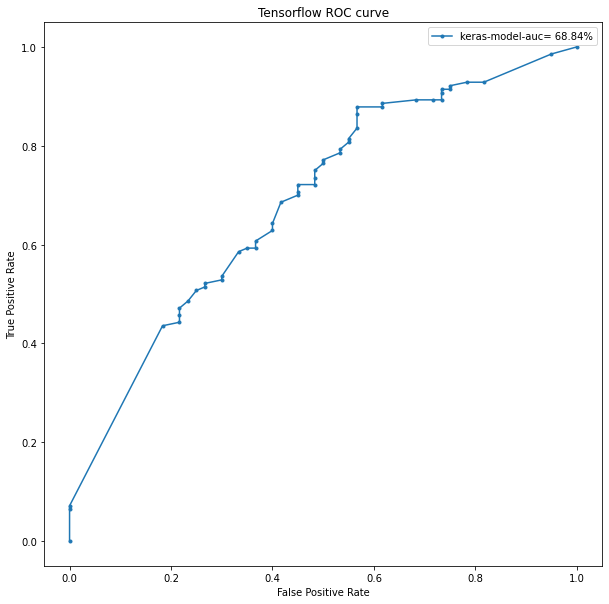

In [254]:
plt.figure(figsize=(10, 10))
plt.title("Tensorflow ROC curve".format(classifier_name))

    
lr_probs = model.predict(new_test_x)
# lr_probs = lr_probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)
a = auc(lr_fpr, lr_tpr)
plt.plot(lr_fpr, lr_tpr, marker='.', label="keras-model-auc= {:.2f}%".format(a * 100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
   

In [248]:
ls

 best-model.h5                    NormalizingNumericalFeatures.ipynb
 Check2Datasets.ipynb             PrimaryAnalysis.ipynb
'Data Qualitity Analysis.ipynb'   sklearn_models_performance.ipynb
'German Credit Analysis.ipynb'    Tensorflow-Models.ipynb
 ImportanceAnalysis.ipynb         Tf-Onehot.ipynb
 insights.ipynb                   Untitled.ipynb


In [255]:
model.save("best-model.hdf5")

In [259]:
import pickle

In [262]:
with open("scalers.json", "wb") as output_file:
    pickle.dump(scalers, output_file)

In [263]:
with open("scalers.json", "rb") as output_file:
    new_scalers = pickle.load(output_file)

In [264]:
new_scalers["Age"].mean_

array([35.546])

In [266]:
scalers["Age"].mean_

array([35.546])

In [267]:
classifiers

{'Decision Tree': DecisionTreeClassifier(max_depth=5),
 'Random Forest': RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10),
 'Neural Net': MLPClassifier(alpha=1, max_iter=1000),
 'AdaBoost': AdaBoostClassifier(),
 'Logistic Regression': LogisticRegression(),
 'Gradient Boosting': GradientBoostingClassifier(),
 'Extra Trees': ExtraTreesClassifier()}

In [268]:
with open("sk-learners.json", "wb") as output_file:
    pickle.dump(classifiers, output_file)